In [32]:
import os
import shutil
import random
import logging
import time
from tempfile import TemporaryDirectory
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision import datasets, models, transforms

# Configurations
cudnn.benchmark = True
plt.ion()  # interactive mode

# Logging Configuration
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

## Preparing a Balanced Subset of the Dataset

To speed up training while maintaining representativeness, we create a smaller, balanced dataset from our large collection (30K real, 90K fake images). We randomly sample 900 real and 900 fake images, then split them into 80% training and 20% validation sets.

The images are organized into resized_data/ for easy use with PyTorch’s ImageFolder:
```
resized_data/
├── train/
│   ├── real/   # 720 images
│   ├── fake/   # 720 images
├── val/
│   ├── real/   # 180 images
│   ├── fake/   # 180 images
```

In [33]:
# Base data path
BASE_DATA_DIR = "data"
RESIZED_DATA_DIR = "resized_data"

# Directories for real and fake images
REAL_DIR = os.path.join(BASE_DATA_DIR, "wiki")  # Path to real images
FAKE_DIRS = ["inpainting", "insight", "text2img"]  # Directories for fake images

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Number of desired images
num_real_images = 5000
num_fake_images = 5000

def create_directories():
    """Creates necessary directories for train and validation sets, removing old data first."""
    for category in ['train', 'val', 'test']:
        for subdir in ['real', 'fake']:
            dir_path = os.path.join(RESIZED_DATA_DIR, category, subdir)

            # Remove all existing files to prevent dataset accumulation
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)

            os.makedirs(dir_path, exist_ok=False)

def get_image_paths(directory):
    """Returns a list of image file paths within a directory structure."""
    image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_paths.extend(
                [
                    os.path.join(subdir_path, file)
                    for file in os.listdir(subdir_path)
                    if os.path.isfile(os.path.join(subdir_path, file))
                ]
            )
    return image_paths

def split_and_copy_images(image_paths, category):
    """Splits images into training, validation and test sets and copies them accordingly."""
    train, val, test = random_split(image_paths, [TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT])

    def save_images(image_paths, destination):
        for image_path in image_paths:
            target_path = os.path.join(RESIZED_DATA_DIR, destination, category, os.path.basename(image_path))
            shutil.copy(image_path, target_path)
    save_images(train, 'train')
    save_images(val, 'val')
    save_images(test, 'test')

# Function to split images into 'train' and 'val'
def organize_data():
    # Create destination directories
    create_directories()

    # Handle real images
    real_images = get_image_paths(REAL_DIR)
    # Random sampling of real images
    sampled_real_images = random.sample(real_images, num_real_images)
    logging.info(f"Sampled {len(sampled_real_images)} real images.")

    # Split into train, val, test and copy to destination
    split_and_copy_images(sampled_real_images, 'real')

    # Handle fake images
    fake_images = []
    for fake_dir in FAKE_DIRS:
        fake_images.extend(get_image_paths(os.path.join(BASE_DATA_DIR, fake_dir)))
    # Random sampling of fake images
    sampled_fake_images = random.sample(fake_images, num_fake_images)
    logging.info(f"Sampled {len(sampled_fake_images)} fake images.")

    # Split into train, val, test and copy to destination
    split_and_copy_images(sampled_fake_images, 'fake')

    logging.info("Data organized successfully.")

organize_data()

2025-03-05 12:16:22,529 - INFO - Sampled 5000 real images.
2025-03-05 12:16:23,119 - INFO - Sampled 5000 fake images.
2025-03-05 12:16:23,605 - INFO - Data organized successfully.


## Loading and Preprocessing the Dataset

We now load the resized dataset and apply appropriate transformations for training and validation:

- **Training data**: Includes random cropping and horizontal flipping for augmentation, helping the model generalize better.
- **Validation data**: Only resized and centered to maintain consistency.
- **Normalization**: Standardizes pixel values using ImageNet’s mean and standard deviation.

In [34]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [35]:
# Data augmentation and normalization for training
# Just normalization for validation
test_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ]
    ),
    "val": test_transform,
    "test": test_transform,
}

# Now pointing to the resized data folder
data_dir = RESIZED_DATA_DIR
SPLITS = ["train", "val", "test"]

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in SPLITS
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=16, shuffle=(x == "train"), num_workers=4
    )
    for x in SPLITS
}
dataset_sizes = {x: len(image_datasets[x]) for x in SPLITS}
class_names = image_datasets["train"].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## Visualizing a Batch of Training Images

Before training, we visualize a batch of images from our training dataset to confirm correct loading and transformations.

- The imshow function denormalizes and displays images in a grid.
- A batch of images is retrieved from the training dataloader.
- Labels are mapped to class names and displayed as titles.

This helps verify data integrity and preprocessing before model training.

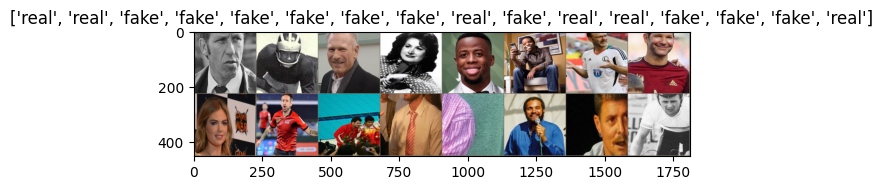

In [36]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

This function trains a deep learning model using supervised learning with PyTorch. Key steps:

- Alternates between training (updating weights) and validation (evaluating performance).
- Uses cross-entropy loss and optimizes with gradient descent.
- Tracks the best validation accuracy, saving model parameters for later use.
- Implements a learning rate scheduler for better convergence.

After training, the model is restored to its best-performing state.

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # Store loss and accuracy values
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                history[f"{phase}_loss"].append(epoch_loss)
                history[f"{phase}_acc"].append(epoch_acc.item())

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, history

## Evaluating Model Predictions

This function visualizes the model’s predictions on validation data:

- The model switches to evaluation mode to disable weight updates.
- Images and predicted labels are displayed alongside ground truth data.
- Helps assess model performance qualitatively by identifying correct and incorrect classifications.

This provides an intuitive check on how well the model generalizes to unseen data.

In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Defining and Optimizing the Model

In this step, we initialize a ResNet-18 model pre-trained on ImageNet (IMAGENET1K_V1) and adapt it for our binary classification task (real vs. fake images). The final fully connected (fc) layer is replaced with a new linear layer that outputs two classes.

We define:
- Loss Function: CrossEntropyLoss, commonly used for classification tasks.
- Optimizer: Stochastic Gradient Descent (SGD) with momentum (0.9) to improve convergence.
- Learning Rate Scheduler: The learning rate decays by a factor of 0.1 every 7 epochs to enhance model stability during training.

In [39]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training the Model

Now, we train our fine-tuned ResNet-18 model using the previously defined optimizer, loss function, and learning rate scheduler. The model will adjust its weights based on our dataset.

Note: In the original tutorial, the model is trained for 25 epochs, but since we are using more images than the tutorial and training on a CPU, I set it to just 1 epoch to keep runtime around 12 minutes.

In [40]:
model_ft, epoch_results = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.6221 Acc: 0.6629
val Loss: 0.4828 Acc: 0.7562

Epoch 1/14
----------
train Loss: 0.5401 Acc: 0.7278
val Loss: 0.4416 Acc: 0.7964

Epoch 2/14
----------
train Loss: 0.4868 Acc: 0.7629
val Loss: 0.4956 Acc: 0.7924

Epoch 3/14
----------
train Loss: 0.4677 Acc: 0.7782
val Loss: 0.4047 Acc: 0.8091

Epoch 4/14
----------
train Loss: 0.4321 Acc: 0.7911
val Loss: 0.4548 Acc: 0.7964

Epoch 5/14
----------
train Loss: 0.4217 Acc: 0.8039
val Loss: 0.3598 Acc: 0.8232

Epoch 6/14
----------
train Loss: 0.3964 Acc: 0.8179
val Loss: 0.4049 Acc: 0.8319

Epoch 7/14
----------
train Loss: 0.3400 Acc: 0.8442
val Loss: 0.3353 Acc: 0.8506

Epoch 8/14
----------
train Loss: 0.3202 Acc: 0.8544
val Loss: 0.3075 Acc: 0.8593

Epoch 9/14
----------
train Loss: 0.3153 Acc: 0.8580
val Loss: 0.3216 Acc: 0.8573

Epoch 10/14
----------
train Loss: 0.3006 Acc: 0.8682
val Loss: 0.3115 Acc: 0.8627

Epoch 11/14
----------
train Loss: 0.2911 Acc: 0.8708
val Loss: 0.3106 Acc: 0.8640

Ep

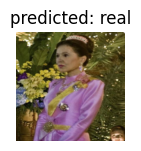

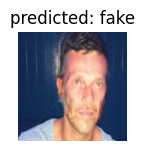

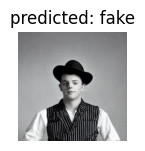

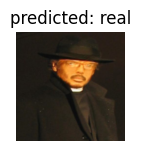

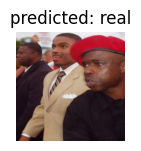

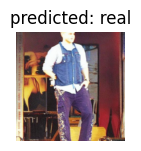

In [41]:
visualize_model(model_ft)

## Feature Extraction with ResNet-18

Instead of fine-tuning all ResNet-18 layers, we freeze the pre-trained weights (requires_grad = False) and only train the final fully connected layer for binary classification. This approach, known as feature extraction, is useful when we have a smaller dataset and want to leverage pre-trained features.

- Only the final layer is optimized, making training more efficient.
- We still use SGD with momentum and a learning rate scheduler to optimize training.

This method ensures we benefit from ResNet’s powerful pre-trained features while reducing the computational cost of training. 

In [42]:
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
model_conv, epoch_results_conv = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.6546 Acc: 0.6253
val Loss: 0.6134 Acc: 0.6778

Epoch 1/14
----------
train Loss: 0.6366 Acc: 0.6478
val Loss: 0.6446 Acc: 0.6551

Epoch 2/14
----------
train Loss: 0.6424 Acc: 0.6456
val Loss: 0.5958 Acc: 0.6885

Epoch 3/14
----------
train Loss: 0.6287 Acc: 0.6561
val Loss: 0.6620 Acc: 0.6551

Epoch 4/14
----------
train Loss: 0.6410 Acc: 0.6574
val Loss: 0.6304 Acc: 0.6631

Epoch 5/14
----------
train Loss: 0.6299 Acc: 0.6618
val Loss: 0.5952 Acc: 0.6892

Epoch 6/14
----------
train Loss: 0.6306 Acc: 0.6536
val Loss: 0.5883 Acc: 0.6986

Epoch 7/14
----------
train Loss: 0.5952 Acc: 0.6826
val Loss: 0.5969 Acc: 0.6785

Epoch 8/14
----------
train Loss: 0.5888 Acc: 0.6913
val Loss: 0.5745 Acc: 0.7086

Epoch 9/14
----------
train Loss: 0.5806 Acc: 0.6972
val Loss: 0.5966 Acc: 0.6798

Epoch 10/14
----------
train Loss: 0.5756 Acc: 0.7047
val Loss: 0.5753 Acc: 0.6993

Epoch 11/14
----------
train Loss: 0.5755 Acc: 0.6958
val Loss: 0.5780 Acc: 0.6952

Ep

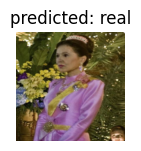

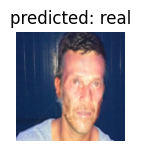

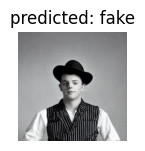

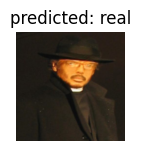

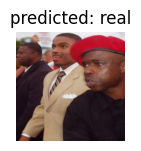

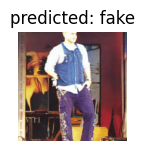

In [44]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Visualizing Model Predictions

This function allows us to visualize the model’s prediction for a given image. It follows these steps:

- Loads the image and applies the same transformations used during validation.
- Converts the image into a format suitable for the model (unsqueeze(0) to add batch dimension).
- Disables gradient computation (torch.no_grad()) for efficient inference.
- Predicts the class and displays the image with its predicted label.

This function helps us qualitatively evaluate the model’s performance by seeing its predictions on real examples.

In [45]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms["val"](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {class_names[preds[0]]}")
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

## Running the Visualization on a Sample Image

Here, we test our trained feature extraction model (model_conv) by passing a real image from the validation set. The model's prediction is displayed alongside the image.

Note: Ensure that the input image is not grayscale. The function expects an RGB image (3 channels), and passing a single-channel grayscale image may lead to errors or unexpected behavior.

In [46]:
visualize_model_predictions(
    model_conv, img_path="resized_data/val/fake/50745_1941-10-13_2011.jpg"
)

plt.ioff()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/minipoloalex/Documents/deeplearning/resized_data/val/fake/50745_1941-10-13_2011.jpg'

## Plotting Classification Performance

In [47]:
def plot_training_history(history, title_label=""):
    if title_label != "":
        title_label = f": {title_label}"
    epochs = range(len(history["train_loss"]))

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.title(f"Training & Validation Loss{title_label}")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training & Validation Accuracy{title_label}")
    plt.legend()

    plt.show()

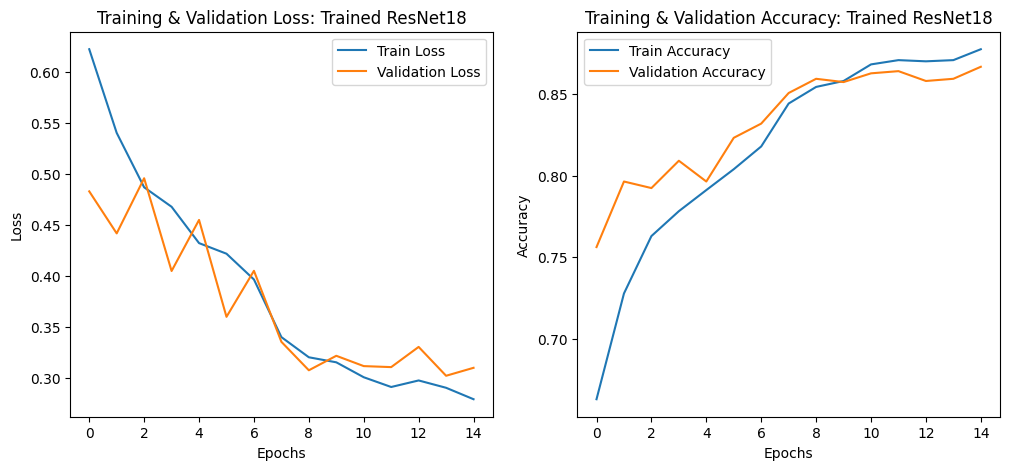

In [48]:
plot_training_history(epoch_results, "Trained ResNet18")

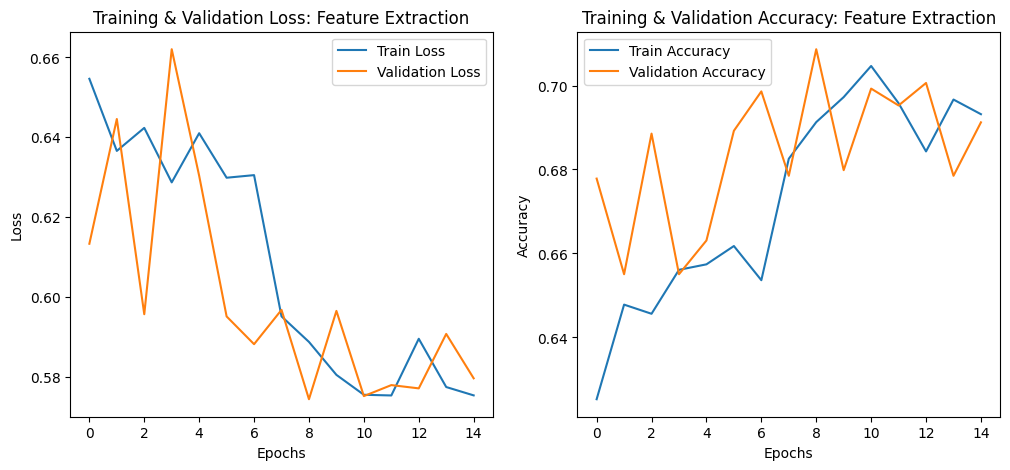

In [49]:
plot_training_history(epoch_results_conv, "Feature Extraction")